<a href="https://colab.research.google.com/github/macbhaldar/Data-Science-Python-Handbook/blob/main/Logistic-Regression/Logistic_Regression_Banking.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import pandas as pd
import numpy as np
from sklearn import preprocessing
import matplotlib.pyplot as plt 
plt.rc("font", size=14)
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
import seaborn as sns
sns.set(style="white")
sns.set(style="whitegrid", color_codes=True)

In [2]:
data = pd.read_csv('banking.csv', header=0)
data = data.dropna()
print(data.shape)
print(list(data.columns))

(17688, 21)
['age', 'job', 'marital', 'education', 'default', 'housing', 'loan', 'contact', 'month', 'day_of_week', 'duration', 'campaign', 'pdays', 'previous', 'poutcome', 'emp_var_rate', 'cons_price_idx', 'cons_conf_idx', 'euribor3m', 'nr_employed', 'y']


In [3]:
data['education'].unique()

array(['basic.4y', 'unknown', 'university.degree', 'high.school',
       'basic.9y', 'professional.course', 'basic.6y', 'illiterate'],
      dtype=object)

In [4]:
data['education']=np.where(data['education'] =='basic.9y', 'Basic', data['education'])
data['education']=np.where(data['education'] =='basic.6y', 'Basic', data['education'])
data['education']=np.where(data['education'] =='basic.4y', 'Basic', data['education'])

In [5]:
data['education'].unique()

array(['Basic', 'unknown', 'university.degree', 'high.school',
       'professional.course', 'illiterate'], dtype=object)

### Data Exploration

In [6]:
data['y'].value_counts()

0.0    15662
1.0     2026
Name: y, dtype: int64

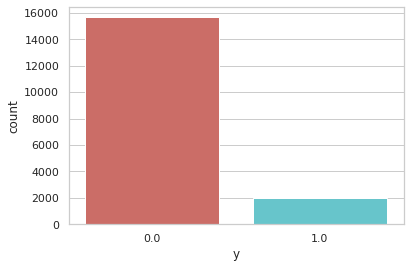

<Figure size 432x288 with 0 Axes>

In [7]:
sns.countplot(x='y', data=data, palette='hls')
plt.show()
plt.savefig('count_plot')

In [8]:
count_no_sub = len(data[data['y']==0])
count_sub = len(data[data['y']==1])
pct_of_no_sub = count_no_sub/(count_no_sub+count_sub)
print("percentage of no subscription is", pct_of_no_sub*100)
pct_of_sub = count_sub/(count_no_sub+count_sub)
print("percentage of subscription", pct_of_sub*100)

percentage of no subscription is 88.54590682948891
percentage of subscription 11.454093170511081


In [9]:
data.groupby('y').mean()

,age,duration,campaign,pdays,previous,emp_var_rate,cons_price_idx,cons_conf_idx,euribor3m,nr_employed
y,,,,,,,,,,
0.0,39.866237,220.363938,2.624697,985.188035,0.133508,0.245224,93.605069,-40.564883,3.806097,5175.826095
1.0,40.843040,554.362784,2.021224,786.746298,0.507897,-1.233416,93.373603,-39.978776,2.106016,5093.940030


#### Observations:
- The average age of customers who bought the term deposit is higher than that of the customers who didn’t.
- The pdays (days since the customer was last contacted) is understandably lower for the customers who bought it. The lower the pdays, the better the memory of the last call and hence the better chances of a sale.
- Surprisingly, campaigns (number of contacts or calls made during the current campaign) are lower for customers who bought the term deposit.

In [10]:
data.groupby('job').mean()

,age,duration,campaign,pdays,previous,emp_var_rate,cons_price_idx,cons_conf_idx,euribor3m,nr_employed,y
job,,,,,,,,,,,
admin.,37.984305,254.634081,2.615471,955.819731,0.190583,0.014215,93.535546,-40.272892,3.546199,5163.680135,0.133632
blue-collar,39.451897,263.467470,2.545592,986.781211,0.117056,0.246898,93.660228,-41.386109,3.763681,5175.431399,0.069329
entrepreneur,41.528594,255.945904,2.550232,980.595054,0.142195,0.147913,93.614836,-41.198609,3.782331,5174.744668,0.094281
housemaid,45.038813,266.200913,2.751142,967.264840,0.116438,0.451142,93.685416,-39.578539,4.022201,5180.493607,0.093607
management,42.383372,247.671286,2.459584,958.474211,0.207082,-0.064434,93.510346,-40.465435,3.545303,5164.145035,0.110855
retired,62.024161,271.336913,2.385235,892.291275,0.351678,-0.714362,93.428569,-38.418121,2.757635,5121.129799,0.261745
self-employed,40.248788,263.544426,2.675283,978.142165,0.174475,0.051858,93.543601,-40.590307,3.659819,5169.221971,0.092084
services,37.983030,267.416364,2.597576,977.936970,0.148485,0.206909,93.648946,-41.274545,3.732398,5172.885091,0.088485
student,26.051282,268.938462,2.130769,856.556410,0.523077,-1.420256,93.334797,-40.481538,1.862562,5085.758205,0.305128


In [11]:
data.groupby('marital').mean()

,age,duration,campaign,pdays,previous,emp_var_rate,cons_price_idx,cons_conf_idx,euribor3m,nr_employed,y
marital,,,,,,,,,,,
divorced,44.793367,259.151531,2.578061,968.075000,0.178061,0.130000,93.588770,-40.814439,3.684070,5170.337347,0.101531
married,42.266810,257.226953,2.555191,966.871706,0.161868,0.178177,93.602570,-40.259195,3.734675,5171.127600,0.105317
single,33.241249,261.181185,2.545545,951.033413,0.205648,-0.158115,93.524829,-40.874682,3.325711,5155.148210,0.139220
unknown,40.810811,284.108108,2.837838,945.594595,0.297297,-0.483784,93.418162,-41.248649,3.042811,5146.778378,0.108108


In [12]:
data.groupby('education').mean()

,age,duration,campaign,pdays,previous,emp_var_rate,cons_price_idx,cons_conf_idx,euribor3m,nr_employed,y
education,,,,,,,,,,,
Basic,42.146170,261.181784,2.532369,975.235763,0.145242,1.624745e-01,93.636321,-40.900334,3.701974,5170.720979,0.088852
high.school,37.884929,263.576342,2.568919,964.870082,0.182133,5.105172e-02,93.589788,-40.895570,3.572382,5165.339718,0.110864
illiterate,47.444444,205.222222,2.222222,999.000000,0.111111,-6.476301e-17,93.404556,-43.177778,3.563111,5177.922222,0.111111
professional.course,40.138414,260.713535,2.548401,959.881297,0.154183,2.184845e-01,93.584808,-40.095532,3.755011,5172.106395,0.121770
university.degree,38.849684,250.001721,2.557277,950.940142,0.205202,-6.209600e-02,93.491582,-40.006464,3.486729,5161.212431,0.137502
unknown,43.023129,268.055782,2.666667,944.980952,0.238095,1.163265e-01,93.694593,-40.069388,3.602273,5160.702313,0.137415


### Visualizations

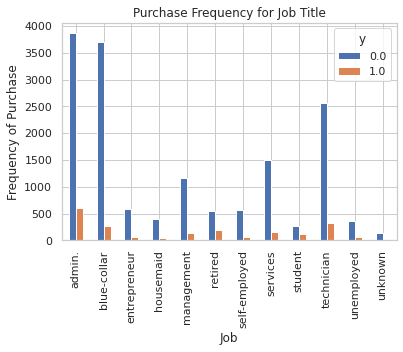

In [13]:
%matplotlib inline
pd.crosstab(data.job,data.y).plot(kind='bar')
plt.title('Purchase Frequency for Job Title')
plt.xlabel('Job')
plt.ylabel('Frequency of Purchase')
plt.savefig('purchase_fre_job')

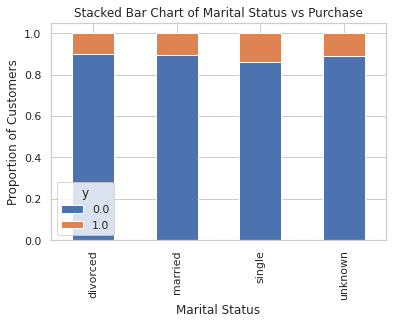

In [14]:
table=pd.crosstab(data.marital,data.y)
table.div(table.sum(1).astype(float), axis=0).plot(kind='bar', stacked=True)
plt.title('Stacked Bar Chart of Marital Status vs Purchase')
plt.xlabel('Marital Status')
plt.ylabel('Proportion of Customers')
plt.savefig('mariral_vs_pur_stack')

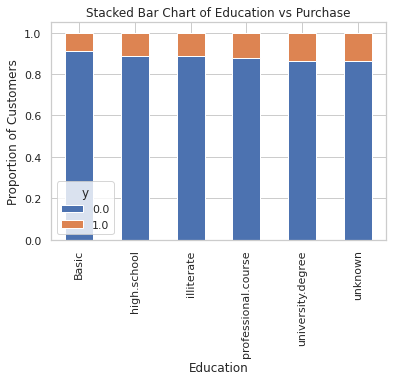

In [15]:
table=pd.crosstab(data.education,data.y)
table.div(table.sum(1).astype(float), axis=0).plot(kind='bar', stacked=True)
plt.title('Stacked Bar Chart of Education vs Purchase')
plt.xlabel('Education')
plt.ylabel('Proportion of Customers')
plt.savefig('edu_vs_pur_stack')

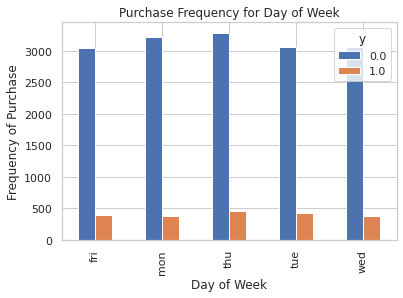

In [16]:
pd.crosstab(data.day_of_week,data.y).plot(kind='bar')
plt.title('Purchase Frequency for Day of Week')
plt.xlabel('Day of Week')
plt.ylabel('Frequency of Purchase')
plt.savefig('pur_dayofweek_bar')

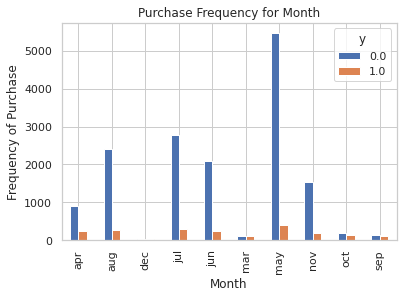

In [17]:
pd.crosstab(data.month,data.y).plot(kind='bar')
plt.title('Purchase Frequency for Month')
plt.xlabel('Month')
plt.ylabel('Frequency of Purchase')
plt.savefig('pur_fre_month_bar')

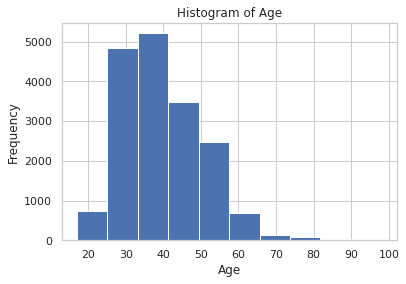

In [18]:
data.age.hist()
plt.title('Histogram of Age')
plt.xlabel('Age')
plt.ylabel('Frequency')
plt.savefig('hist_age')

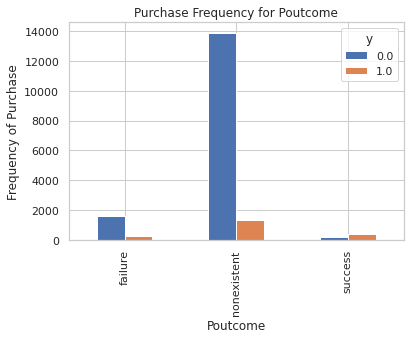

In [19]:
pd.crosstab(data.poutcome,data.y).plot(kind='bar')
plt.title('Purchase Frequency for Poutcome')
plt.xlabel('Poutcome')
plt.ylabel('Frequency of Purchase')
plt.savefig('pur_fre_pout_bar')

### Create dummy variables
That is variables with only two values, zero and one.

In [20]:
cat_vars=['job','marital','education','default','housing','loan','contact','month','day_of_week','poutcome']
for var in cat_vars:
    cat_list='var'+'_'+var
    cat_list = pd.get_dummies(data[var], prefix=var)
    data1=data.join(cat_list)
    data=data1
cat_vars=['job','marital','education','default','housing','loan','contact','month','day_of_week','poutcome']
data_vars=data.columns.values.tolist()
to_keep=[i for i in data_vars if i not in cat_vars]

In [21]:
# Our final data columns will be:
data_final=data[to_keep]
data_final.columns.values

array(['age', 'duration', 'campaign', 'pdays', 'previous', 'emp_var_rate',
       'cons_price_idx', 'cons_conf_idx', 'euribor3m', 'nr_employed', 'y',
       'job_admin.', 'job_blue-collar', 'job_entrepreneur',
       'job_housemaid', 'job_management', 'job_retired',
       'job_self-employed', 'job_services', 'job_student',
       'job_technician', 'job_unemployed', 'job_unknown',
       'marital_divorced', 'marital_married', 'marital_single',
       'marital_unknown', 'education_Basic', 'education_high.school',
       'education_illiterate', 'education_professional.course',
       'education_university.degree', 'education_unknown', 'default_no',
       'default_unknown', 'default_yes', 'housing_no', 'housing_unknown',
       'housing_yes', 'loan_no', 'loan_unknown', 'loan_yes',
       'contact_cellular', 'contact_telephone', 'month_apr', 'month_aug',
       'month_dec', 'month_jul', 'month_jun', 'month_mar', 'month_may',
       'month_nov', 'month_oct', 'month_sep', 'day_of_week_fri',

Over-sampling using SMOTE
With our training data created, I’ll up-sample the no-subscription using the SMOTE algorithm(Synthetic Minority Oversampling Technique). At a high level, SMOTE:
1. Works by creating synthetic samples from the minor class (no-subscription) instead of creating copies.
2. Randomly choosing one of the k-nearest-neighbors and using it to create a similar, but randomly tweaked, new observations.

In [23]:
pip install imblearn

In [27]:
X = data_final.loc[:, data_final.columns != 'y']
y = data_final.loc[:, data_final.columns == 'y']
from imblearn.over_sampling import SMOTE
os = SMOTE(random_state=0)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=0)
columns = X_train.columns
os_data_X,os_data_y=os.fit_resample(X_train, y_train)
os_data_X = pd.DataFrame(data=os_data_X,columns=columns )
os_data_y= pd.DataFrame(data=os_data_y,columns=['y'])
# we can Check the numbers of our data
print("length of oversampled data is ",len(os_data_X))
print("Number of no subscription in oversampled data",len(os_data_y[os_data_y['y']==0]))
print("Number of subscription",len(os_data_y[os_data_y['y']==1]))
print("Proportion of no subscription data in oversampled data is ",len(os_data_y[os_data_y['y']==0])/len(os_data_X))
print("Proportion of subscription data in oversampled data is ",len(os_data_y[os_data_y['y']==1])/len(os_data_X))

length of oversampled data is  21904
Number of no subscription in oversampled data 10952
Number of subscription 10952
Proportion of no subscription data in oversampled data is  0.5
Proportion of subscription data in oversampled data is  0.5


### Recursive Feature Elimination

In [46]:
data_final_vars=data_final.columns.values.tolist()
y=['y']
X=[i for i in data_final_vars if i not in y]

In [48]:
from sklearn import datasets
from sklearn.feature_selection import RFE
from sklearn.linear_model import LogisticRegression

logreg = LogisticRegression()

rfe = RFE(logreg, 20)
rfe = rfe.fit(os_data_X, os_data_y.values.ravel())
print(rfe.support_)
print(rfe.ranking_)

TypeError: ignored

In [37]:
cols=['euribor3m', 'job_blue-collar', 'job_housemaid', 'marital_unknown', 'education_illiterate', 'default_no', 'default_unknown', 
      'contact_cellular', 'contact_telephone', 'month_apr', 'month_aug', 'month_dec', 'month_jul', 'month_jun', 'month_mar', 
      'month_may', 'month_nov', 'month_oct', "poutcome_failure", "poutcome_success"] 
X=os_data_X[cols]
y=os_data_y['y']

### Implementing the model

In [38]:
import statsmodels.api as sm
logit_model=sm.Logit(y,X)
result=logit_model.fit()
print(result.summary2())

/usr/local/lib/python3.7/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


Optimization terminated successfully.
         Current function value: 0.438458
         Iterations 7
                           Results: Logit
Model:                Logit             Pseudo R-squared:  0.367     
Dependent Variable:   y                 AIC:               19247.9755
Date:                 2022-03-17 06:53  BIC:               19407.8640
No. Observations:     21904             Log-Likelihood:    -9604.0   
Df Model:             19                LL-Null:           -15183.   
Df Residuals:         21884             LLR p-value:       0.0000    
Converged:            1.0000            Scale:             1.0000    
No. Iterations:       7.0000                                         
---------------------------------------------------------------------
                      Coef.  Std.Err.    z     P>|z|   [0.025  0.975]
---------------------------------------------------------------------
euribor3m             0.1306   0.0123  10.6036 0.0000  0.1065  0.1547
job_blue-collar 

In [39]:
cols=['euribor3m', 'job_blue-collar', 'job_housemaid', 'marital_unknown', 'education_illiterate', 
      'month_apr', 'month_aug', 'month_dec', 'month_jul', 'month_jun', 'month_mar', 
      'month_may', 'month_nov', 'month_oct', "poutcome_failure", "poutcome_success"] 
X=os_data_X[cols]
y=os_data_y['y']
logit_model=sm.Logit(y,X)
result=logit_model.fit()
print(result.summary2())

Optimization terminated successfully.
         Current function value: 0.530506
         Iterations 7
                           Results: Logit
Model:                Logit             Pseudo R-squared:  0.235     
Dependent Variable:   y                 AIC:               23272.3944
Date:                 2022-03-17 06:54  BIC:               23400.3052
No. Observations:     21904             Log-Likelihood:    -11620.   
Df Model:             15                LL-Null:           -15183.   
Df Residuals:         21888             LLR p-value:       0.0000    
Converged:            1.0000            Scale:             1.0000    
No. Iterations:       7.0000                                         
---------------------------------------------------------------------
                      Coef.  Std.Err.    z     P>|z|   [0.025  0.975]
---------------------------------------------------------------------
euribor3m             0.1972   0.0086  22.8511 0.0000  0.1803  0.2141
job_blue-collar 

### Logistic Regression Model Fitting

In [40]:
from sklearn.linear_model import LogisticRegression
from sklearn import metrics
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=0)
logreg = LogisticRegression()
logreg.fit(X_train, y_train)

/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:818: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG,


LogisticRegression()

#### Predicting the test set results and calculating the accuracy

In [41]:
y_pred = logreg.predict(X_test)
print('Accuracy of logistic regression classifier on test set: {:.2f}'.format(logreg.score(X_test, y_test)))

Accuracy of logistic regression classifier on test set: 0.83


### Confusion Matrix

In [42]:
from sklearn.metrics import confusion_matrix
confusion_matrix = confusion_matrix(y_test, y_pred)
print(confusion_matrix)

[[2886  366]
 [ 722 2598]]


The result is telling us that we have 2886+2598 correct predictions and 366+722 incorrect predictions.

### Compute precision, recall, F-measure and support

In [43]:
from sklearn.metrics import classification_report
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

         0.0       0.80      0.89      0.84      3252
         1.0       0.88      0.78      0.83      3320

    accuracy                           0.83      6572
   macro avg       0.84      0.83      0.83      6572
weighted avg       0.84      0.83      0.83      6572



Interpretation: Of the entire test set, 83% of the promoted term deposit were the term deposit that the customers liked. Of the entire test set, 783 of the customer’s preferred term deposits that were promoted.

### ROC Curve

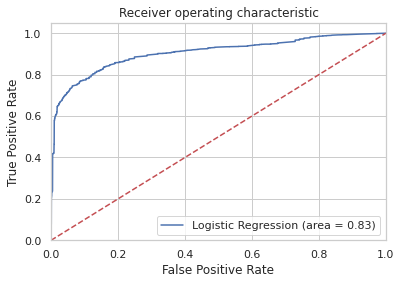

In [44]:
from sklearn.metrics import roc_auc_score
from sklearn.metrics import roc_curve
logit_roc_auc = roc_auc_score(y_test, logreg.predict(X_test))
fpr, tpr, thresholds = roc_curve(y_test, logreg.predict_proba(X_test)[:,1])
plt.figure()
plt.plot(fpr, tpr, label='Logistic Regression (area = %0.2f)' % logit_roc_auc)
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic')
plt.legend(loc="lower right")
plt.savefig('Log_ROC')
plt.show()